
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/content/project/input"


In [2]:
os.makedirs('./project/input', exist_ok=True)
os.makedirs('./project/output', exist_ok=True)
%cd project

/content/project


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest X-ray(512).zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input')

In [6]:
%pwd

'/content/project'

In [7]:
df = pd.read_csv('./input/train.csv')

In [8]:
df['class_id'].unique()

array([14,  3, 10, 11,  0, 13,  5,  8,  9,  7,  6,  4,  2,  1, 12])

In [9]:
# nofinding 제거 버전
df = pd.read_csv('./input/train.csv')
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

,image_id,class_id,x_min,y_min,x_max,y_max
6,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.092308,301.369863,406.892308,401.315068
7,9a5094b2563a1ef3ff50dc5c7ff71345,11,440.369231,378.958904,461.538462,436.602740
8,9a5094b2563a1ef3ff50dc5c7ff71345,12,440.369231,378.958904,461.538462,436.602740
9,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.338462,301.369863,407.876923,394.301370
10,9a5094b2563a1ef3ff50dc5c7ff71345,4,169.600000,287.780822,410.092308,386.410959
...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,10,67.333333,256.355556,85.111111,268.088889
67775,52951d7de2485aba8ed62629eee4d254,4,163.111111,279.288889,358.666667,336.355556
67848,1224f07d895107573588225f692e94f9,1,250.729412,161.922261,320.250980,223.434629
67849,1224f07d895107573588225f692e94f9,1,262.525490,155.590106,319.247059,221.399293


In [10]:
print("df Shape: "+str(df.shape))
print("No Of Classes: "+str(df["class_id"].nunique()))
df.sort_values(by='image_id').head(10)
len(df)


df Shape: (36096, 6)
No Of Classes: 14


36096

In [11]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    res['images'].append({
        'id': pic_name,
        'width': 512,
        'height':512,
        'file_name': pic_name+".png"
    })
      
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [12]:
random.seed(10)

train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [13]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [14]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [15]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

!pip show torch

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


런타임 다시 시작하고 진행합니다.

In [16]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 32083, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 32083 (delta 70), reused 99 (delta 26), pack-reused 31875
Receiving objects: 100% (32083/32083), 41.06 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (23046/23046), done.


In [17]:
%cd ./mmdetection

/content/project/mmdetection


In [18]:
!pip install openmim
!mim install mmdet==2.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 237 kB 94.1 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 1.3 MB 32.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 728 kB 36.1 MB/s 
Saved /tmp/tmpji99a135/mmdet-2.22.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.22.0: ['mmcv-full>=1.3.17'].
     |████████████████████████████████| 40.6 MB 541 kB/s 
     |████████████████████████████████| 190 kB 100.2 MB/s 
Using cached `mminstall.txt` for mmdet==2.22.0: 

=========

In [19]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True
2.25.2
11.3
GCC 9.3


In [20]:
%pwd

'/content/project/mmdetection'

In [21]:
!mkdir checkpoints

In [22]:
%cd /content/project/mmdetection/checkpoints

/content/project/mmdetection/checkpoints


In [23]:
# Download pretrain weight from mmdetection github (CenterNet R-18 and Retina ResNet-101)
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth \
      -O /content/project/mmdetection/checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth

--2022-10-23 11:44:48--  https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.74.197.92
Connecting to download.openmmlab.com (download.openmmlab.com)|47.74.197.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176992053 (169M) [application/octet-stream]
Saving to: ‘/content/project/mmdetection/checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’

/content/project/mm 100%[===================>] 168.79M  9.60MB/s    in 18s     

2022-10-23 11:45:07 (9.41 MB/s) - ‘/content/project/mmdetection/checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’ saved [176992053/176992053]



In [24]:
config = "/content/project/mmdetection/configs/yolof/yolof_r50_c5_8x8_1x_coco.py"
checkpoint = "/content/project/mmdetection/checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth"

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [25]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [26]:
from mmcv import Config
cfg = Config.fromfile(config)

In [27]:
print(f'Config:\n{cfg.pretty_text}')


Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomShift', shift_ratio=0.5, max_shift_px=32),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [28]:
from mmdet.apis import set_random_seed

base_path = '/content/project/input' # base_dir과 같습니다.

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/project/vinBigData/yolof/1'

EPOCHS= 30


In [29]:
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"
valid_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"

train_img = "train" # 출력은 "train_100000"
valid_img = 'train'
test_img =  "test" # 출력은 "train_100000"



# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = valid_anno
cfg.data.val.img_prefix = valid_img

#test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img



cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
# 직접 가서 바꿈 !!!!!
cfg.model.bbox_head['num_classes'] = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

cfg.load_from = checkpoint
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = None


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer = dict(type='Adam', lr=0.0003, weight_decay=0.0001)
#cfg.optimizer.lr = 0.02 / 8 # 0.0025
# learning rate
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


"""
cfg.model.roi_head.init_cfg =
cfg.model.rpn_head.init_cfg =
cfg.model.neck.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))

cfg.model.backbone.frozen_stage= -1
"""


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
dataset_type = 'CocoDataset'
data_root = '/content/project/input'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomShift', shift_ratio=0.5, max_shift_px=32),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
        

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

In [ ]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-22 16:40:32,281 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-22 16:40:32,323 - mmdet - INFO - load checkpoint from local path: /content/project/mmdetection/checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
2022-10-22 16:40:32,458 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_score.weight: copying a param with shape torch.Size([400, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([70, 512, 3, 3]).
size mismatch for bbox_head.cls_score.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([70]).
2022-10-22 16:40:32,463 - mmdet - INFO - Start running, host: root@23563787332e, work_dir: /content/drive/MyDrive/project/vinBigData/yolof/1
2022-10-22 16:40:32,464 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL  

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-22 16:40:48,029 - mmdet - INFO - Epoch [1][10/440]	lr: 3.000e-04, eta: 5:41:03, time: 1.551, data_time: 0.258, memory: 5354, loss_cls: 0.9036, loss_bbox: 1.1398, loss: 2.0434
2022-10-22 16:40:55,322 - mmdet - INFO - Epoch [1][20/440]	lr: 3.000e-04, eta: 4:10:29, time: 0.729, data_time: 0.019, memory: 5354, loss_cls: 0.6169, loss_bbox: 1.0663, loss: 1.6832
2022-10-22 16:41:02,633 - mmdet - INFO - Epoch [1][30/440]	lr: 3.000e-04, eta: 3:40:21, time: 0.731, data_time: 0.019, memory: 5354, loss_cls: 0.5728, loss_bbox: 0.9160, loss: 1.4888
2022-10-22 16:41:09,979 - mmdet - INFO - Epoch [1][40/440]	lr: 3.000e-04, eta: 3:25:24, time: 0.734, data_time: 0.019, memory: 5354, loss_cls: 0.5488, loss_bbox: 0.9170, loss: 1.4658
2022-10-22 16:41:17,378 - mmdet - INFO - Epoch [1][50/440]	lr: 3.000e-04, eta: 3:16:38, time: 0.740, data_time: 0.020, memory: 5354, loss_cls: 0.4956, loss_bbox: 0.9453, loss: 1.4409
2022-10-22 16:41:24,839 - mmdet - INFO - Epoch [1][60/440]	lr: 3.000e-04, eta: 3:10:5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 16:47:07,885 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.33s).
Accumulating evaluation results...


2022-10-22 16:47:16,241 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.176
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.26s).


2022-10-22 16:47:26,505 - mmdet - INFO - Epoch [2][10/440]	lr: 3.000e-04, eta: 2:48:05, time: 1.009, data_time: 0.256, memory: 5354, loss_cls: 0.3633, loss_bbox: 0.6961, loss: 1.0594
2022-10-22 16:47:34,235 - mmdet - INFO - Epoch [2][20/440]	lr: 3.000e-04, eta: 2:47:52, time: 0.773, data_time: 0.020, memory: 5354, loss_cls: 0.3626, loss_bbox: 0.7145, loss: 1.0771
2022-10-22 16:47:42,040 - mmdet - INFO - Epoch [2][30/440]	lr: 3.000e-04, eta: 2:47:41, time: 0.780, data_time: 0.020, memory: 5354, loss_cls: 0.3630, loss_bbox: 0.7299, loss: 1.0929
2022-10-22 16:47:49,901 - mmdet - INFO - Epoch [2][40/440]	lr: 3.000e-04, eta: 2:47:32, time: 0.786, data_time: 0.020, memory: 5354, loss_cls: 0.3743, loss_bbox: 0.7002, loss: 1.0745
2022-10-22 16:47:57,764 - mmdet - INFO - Epoch [2][50/440]	lr: 3.000e-04, eta: 2:47:23, time: 0.786, data_time: 0.019, memory: 5354, loss_cls: 0.3747, loss_bbox: 0.8246, loss: 1.1992
2022-10-22 16:48:05,563 - mmdet - INFO - Epoch [2][60/440]	lr: 3.000e-04, eta: 2:47:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 16:53:48,356 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.49s).
Accumulating evaluation results...


2022-10-22 16:53:56,994 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.195
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.19s).


2022-10-22 16:54:07,246 - mmdet - INFO - Epoch [3][10/440]	lr: 3.000e-04, eta: 2:41:06, time: 1.008, data_time: 0.256, memory: 5354, loss_cls: 0.3505, loss_bbox: 0.7096, loss: 1.0601
2022-10-22 16:54:14,974 - mmdet - INFO - Epoch [3][20/440]	lr: 3.000e-04, eta: 2:40:57, time: 0.773, data_time: 0.019, memory: 5354, loss_cls: 0.3619, loss_bbox: 0.6912, loss: 1.0531
2022-10-22 16:54:22,758 - mmdet - INFO - Epoch [3][30/440]	lr: 3.000e-04, eta: 2:40:48, time: 0.778, data_time: 0.020, memory: 5354, loss_cls: 0.3097, loss_bbox: 0.6704, loss: 0.9801
2022-10-22 16:54:30,608 - mmdet - INFO - Epoch [3][40/440]	lr: 3.000e-04, eta: 2:40:40, time: 0.785, data_time: 0.019, memory: 5354, loss_cls: 0.3330, loss_bbox: 0.6292, loss: 0.9622
2022-10-22 16:54:38,457 - mmdet - INFO - Epoch [3][50/440]	lr: 3.000e-04, eta: 2:40:32, time: 0.785, data_time: 0.019, memory: 5354, loss_cls: 0.3268, loss_bbox: 0.6761, loss: 1.0029
2022-10-22 16:54:46,237 - mmdet - INFO - Epoch [3][60/440]	lr: 3.000e-04, eta: 2:40:2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:00:28,116 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.45s).
Accumulating evaluation results...


2022-10-22 17:00:36,625 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.14s).


2022-10-22 17:00:46,876 - mmdet - INFO - Epoch [4][10/440]	lr: 3.000e-04, eta: 2:34:53, time: 1.008, data_time: 0.256, memory: 5354, loss_cls: 0.3506, loss_bbox: 0.6769, loss: 1.0275
2022-10-22 17:00:54,582 - mmdet - INFO - Epoch [4][20/440]	lr: 3.000e-04, eta: 2:34:44, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.3402, loss_bbox: 0.6685, loss: 1.0087
2022-10-22 17:01:02,366 - mmdet - INFO - Epoch [4][30/440]	lr: 3.000e-04, eta: 2:34:36, time: 0.778, data_time: 0.019, memory: 5354, loss_cls: 0.3332, loss_bbox: 0.6723, loss: 1.0054
2022-10-22 17:01:10,210 - mmdet - INFO - Epoch [4][40/440]	lr: 3.000e-04, eta: 2:34:28, time: 0.784, data_time: 0.019, memory: 5354, loss_cls: 0.3251, loss_bbox: 0.6962, loss: 1.0212
2022-10-22 17:01:18,041 - mmdet - INFO - Epoch [4][50/440]	lr: 3.000e-04, eta: 2:34:20, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.3393, loss_bbox: 0.6731, loss: 1.0124
2022-10-22 17:01:25,812 - mmdet - INFO - Epoch [4][60/440]	lr: 3.000e-04, eta: 2:34:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:07:07,652 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...


2022-10-22 17:07:16,018 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.20s).


2022-10-22 17:07:26,281 - mmdet - INFO - Epoch [5][10/440]	lr: 3.000e-04, eta: 2:28:53, time: 1.009, data_time: 0.257, memory: 5354, loss_cls: 0.3441, loss_bbox: 0.6477, loss: 0.9918
2022-10-22 17:07:33,992 - mmdet - INFO - Epoch [5][20/440]	lr: 3.000e-04, eta: 2:28:44, time: 0.771, data_time: 0.020, memory: 5354, loss_cls: 0.3380, loss_bbox: 0.6698, loss: 1.0078
2022-10-22 17:07:41,767 - mmdet - INFO - Epoch [5][30/440]	lr: 3.000e-04, eta: 2:28:36, time: 0.777, data_time: 0.020, memory: 5354, loss_cls: 0.3457, loss_bbox: 0.6827, loss: 1.0283
2022-10-22 17:07:49,593 - mmdet - INFO - Epoch [5][40/440]	lr: 3.000e-04, eta: 2:28:29, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.3631, loss_bbox: 0.6823, loss: 1.0454
2022-10-22 17:07:57,413 - mmdet - INFO - Epoch [5][50/440]	lr: 3.000e-04, eta: 2:28:21, time: 0.782, data_time: 0.019, memory: 5354, loss_cls: 0.3139, loss_bbox: 0.6769, loss: 0.9908
2022-10-22 17:08:05,165 - mmdet - INFO - Epoch [5][60/440]	lr: 3.000e-04, eta: 2:28:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:13:46,614 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.74s).
Accumulating evaluation results...


2022-10-22 17:13:54,252 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.201
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.14s).


2022-10-22 17:14:04,472 - mmdet - INFO - Epoch [6][10/440]	lr: 3.000e-04, eta: 2:22:58, time: 1.005, data_time: 0.257, memory: 5354, loss_cls: 0.3342, loss_bbox: 0.6217, loss: 0.9560
2022-10-22 17:14:12,160 - mmdet - INFO - Epoch [6][20/440]	lr: 3.000e-04, eta: 2:22:49, time: 0.769, data_time: 0.020, memory: 5354, loss_cls: 0.3319, loss_bbox: 0.6806, loss: 1.0125
2022-10-22 17:14:19,895 - mmdet - INFO - Epoch [6][30/440]	lr: 3.000e-04, eta: 2:22:41, time: 0.773, data_time: 0.019, memory: 5354, loss_cls: 0.3318, loss_bbox: 0.6373, loss: 0.9692
2022-10-22 17:14:27,705 - mmdet - INFO - Epoch [6][40/440]	lr: 3.000e-04, eta: 2:22:33, time: 0.781, data_time: 0.019, memory: 5354, loss_cls: 0.3191, loss_bbox: 0.6661, loss: 0.9852
2022-10-22 17:14:35,520 - mmdet - INFO - Epoch [6][50/440]	lr: 3.000e-04, eta: 2:22:26, time: 0.781, data_time: 0.019, memory: 5354, loss_cls: 0.3157, loss_bbox: 0.6350, loss: 0.9507
2022-10-22 17:14:43,285 - mmdet - INFO - Epoch [6][60/440]	lr: 3.000e-04, eta: 2:22:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:20:24,191 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.45s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.35s).
Accumulating evaluation results...


2022-10-22 17:20:32,538 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.245
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-10-22 17:20:42,757 - mmdet - INFO - Epoch [7][10/440]	lr: 3.000e-04, eta: 2:17:05, time: 1.005, data_time: 0.255, memory: 5354, loss_cls: 0.3362, loss_bbox: 0.6238, loss: 0.9600
2022-10-22 17:20:50,460 - mmdet - INFO - Epoch [7][20/440]	lr: 3.000e-04, eta: 2:16:57, time: 0.770, data_time: 0.019, memory: 5354, loss_cls: 0.3078, loss_bbox: 0.6478, loss: 0.9556
2022-10-22 17:20:58,206 - mmdet - INFO - Epoch [7][30/440]	lr: 3.000e-04, eta: 2:16:49, time: 0.774, data_time: 0.020, memory: 5354, loss_cls: 0.3213, loss_bbox: 0.6307, loss: 0.9520
2022-10-22 17:21:06,015 - mmdet - INFO - Epoch [7][40/440]	lr: 3.000e-04, eta: 2:16:41, time: 0.781, data_time: 0.020, memory: 5354, loss_cls: 0.3256, loss_bbox: 0.7113, loss: 1.0369
2022-10-22 17:21:13,816 - mmdet - INFO - Epoch [7][50/440]	lr: 3.000e-04, eta: 2:16:33, time: 0.780, data_time: 0.020, memory: 5354, loss_cls: 0.3127, loss_bbox: 0.6135, loss: 0.9261
2022-10-22 17:21:21,549 - mmdet - INFO - Epoch [7][60/440]	lr: 3.000e-04, eta: 2:16:2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:27:01,906 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.45s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.85s).
Accumulating evaluation results...


2022-10-22 17:27:10,039 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.221
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.36s).


2022-10-22 17:27:20,241 - mmdet - INFO - Epoch [8][10/440]	lr: 3.000e-04, eta: 2:11:14, time: 1.003, data_time: 0.254, memory: 5354, loss_cls: 0.3325, loss_bbox: 0.6527, loss: 0.9852
2022-10-22 17:27:27,939 - mmdet - INFO - Epoch [8][20/440]	lr: 3.000e-04, eta: 2:11:06, time: 0.770, data_time: 0.020, memory: 5354, loss_cls: 0.2831, loss_bbox: 0.6071, loss: 0.8902
2022-10-22 17:27:35,686 - mmdet - INFO - Epoch [8][30/440]	lr: 3.000e-04, eta: 2:10:58, time: 0.775, data_time: 0.019, memory: 5354, loss_cls: 0.3021, loss_bbox: 0.6395, loss: 0.9416
2022-10-22 17:27:43,487 - mmdet - INFO - Epoch [8][40/440]	lr: 3.000e-04, eta: 2:10:50, time: 0.780, data_time: 0.020, memory: 5354, loss_cls: 0.3284, loss_bbox: 0.6687, loss: 0.9971
2022-10-22 17:27:51,293 - mmdet - INFO - Epoch [8][50/440]	lr: 3.000e-04, eta: 2:10:43, time: 0.781, data_time: 0.020, memory: 5354, loss_cls: 0.3101, loss_bbox: 0.6313, loss: 0.9414
2022-10-22 17:27:59,044 - mmdet - INFO - Epoch [8][60/440]	lr: 3.000e-04, eta: 2:10:3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:33:39,622 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.21s).
Accumulating evaluation results...


2022-10-22 17:33:47,868 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.12s).


2022-10-22 17:33:58,087 - mmdet - INFO - Epoch [9][10/440]	lr: 3.000e-05, eta: 2:05:26, time: 1.005, data_time: 0.255, memory: 5354, loss_cls: 0.3149, loss_bbox: 0.6485, loss: 0.9634
2022-10-22 17:34:05,750 - mmdet - INFO - Epoch [9][20/440]	lr: 3.000e-05, eta: 2:05:18, time: 0.766, data_time: 0.019, memory: 5354, loss_cls: 0.3179, loss_bbox: 0.6020, loss: 0.9199
2022-10-22 17:34:13,490 - mmdet - INFO - Epoch [9][30/440]	lr: 3.000e-05, eta: 2:05:10, time: 0.774, data_time: 0.019, memory: 5354, loss_cls: 0.2631, loss_bbox: 0.5731, loss: 0.8362
2022-10-22 17:34:21,279 - mmdet - INFO - Epoch [9][40/440]	lr: 3.000e-05, eta: 2:05:03, time: 0.779, data_time: 0.019, memory: 5354, loss_cls: 0.2981, loss_bbox: 0.6182, loss: 0.9163
2022-10-22 17:34:29,082 - mmdet - INFO - Epoch [9][50/440]	lr: 3.000e-05, eta: 2:04:55, time: 0.780, data_time: 0.019, memory: 5354, loss_cls: 0.2854, loss_bbox: 0.6077, loss: 0.8931
2022-10-22 17:34:36,821 - mmdet - INFO - Epoch [9][60/440]	lr: 3.000e-05, eta: 2:04:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:40:17,133 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.33s).
Accumulating evaluation results...


2022-10-22 17:40:25,466 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.123
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-10-22 17:40:35,680 - mmdet - INFO - Epoch [10][10/440]	lr: 3.000e-05, eta: 1:59:40, time: 1.004, data_time: 0.256, memory: 5354, loss_cls: 0.2749, loss_bbox: 0.5435, loss: 0.8184
2022-10-22 17:40:43,370 - mmdet - INFO - Epoch [10][20/440]	lr: 3.000e-05, eta: 1:59:32, time: 0.769, data_time: 0.020, memory: 5354, loss_cls: 0.2731, loss_bbox: 0.5851, loss: 0.8581
2022-10-22 17:40:51,131 - mmdet - INFO - Epoch [10][30/440]	lr: 3.000e-05, eta: 1:59:24, time: 0.776, data_time: 0.019, memory: 5354, loss_cls: 0.2583, loss_bbox: 0.5768, loss: 0.8352
2022-10-22 17:40:58,957 - mmdet - INFO - Epoch [10][40/440]	lr: 3.000e-05, eta: 1:59:16, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.2801, loss_bbox: 0.6184, loss: 0.8985
2022-10-22 17:41:06,763 - mmdet - INFO - Epoch [10][50/440]	lr: 3.000e-05, eta: 1:59:08, time: 0.781, data_time: 0.021, memory: 5354, loss_cls: 0.2585, loss_bbox: 0.5463, loss: 0.8048
2022-10-22 17:41:14,500 - mmdet - INFO - Epoch [10][60/440]	lr: 3.000e-05, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:46:55,374 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.33s).
Accumulating evaluation results...


2022-10-22 17:47:03,580 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.315
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.11s).


2022-10-22 17:47:13,820 - mmdet - INFO - Epoch [11][10/440]	lr: 3.000e-05, eta: 1:53:55, time: 1.007, data_time: 0.255, memory: 5354, loss_cls: 0.2689, loss_bbox: 0.5879, loss: 0.8569
2022-10-22 17:47:21,518 - mmdet - INFO - Epoch [11][20/440]	lr: 3.000e-05, eta: 1:53:47, time: 0.770, data_time: 0.019, memory: 5354, loss_cls: 0.2543, loss_bbox: 0.5890, loss: 0.8433
2022-10-22 17:47:29,275 - mmdet - INFO - Epoch [11][30/440]	lr: 3.000e-05, eta: 1:53:39, time: 0.776, data_time: 0.020, memory: 5354, loss_cls: 0.2694, loss_bbox: 0.5704, loss: 0.8398
2022-10-22 17:47:37,092 - mmdet - INFO - Epoch [11][40/440]	lr: 3.000e-05, eta: 1:53:32, time: 0.782, data_time: 0.019, memory: 5354, loss_cls: 0.2619, loss_bbox: 0.5272, loss: 0.7891
2022-10-22 17:47:44,910 - mmdet - INFO - Epoch [11][50/440]	lr: 3.000e-05, eta: 1:53:24, time: 0.782, data_time: 0.019, memory: 5354, loss_cls: 0.2660, loss_bbox: 0.5789, loss: 0.8449
2022-10-22 17:47:52,655 - mmdet - INFO - Epoch [11][60/440]	lr: 3.000e-05, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 17:53:34,128 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.45s).
Accumulating evaluation results...


2022-10-22 17:53:42,427 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.309
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-10-22 17:53:52,648 - mmdet - INFO - Epoch [12][10/440]	lr: 3.000e-06, eta: 1:48:12, time: 1.006, data_time: 0.256, memory: 5354, loss_cls: 0.2580, loss_bbox: 0.5289, loss: 0.7868
2022-10-22 17:54:00,336 - mmdet - INFO - Epoch [12][20/440]	lr: 3.000e-06, eta: 1:48:04, time: 0.769, data_time: 0.019, memory: 5354, loss_cls: 0.2619, loss_bbox: 0.5745, loss: 0.8364
2022-10-22 17:54:08,094 - mmdet - INFO - Epoch [12][30/440]	lr: 3.000e-06, eta: 1:47:56, time: 0.776, data_time: 0.019, memory: 5354, loss_cls: 0.2372, loss_bbox: 0.5403, loss: 0.7775
2022-10-22 17:54:15,924 - mmdet - INFO - Epoch [12][40/440]	lr: 3.000e-06, eta: 1:47:48, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.2516, loss_bbox: 0.5309, loss: 0.7825
2022-10-22 17:54:23,735 - mmdet - INFO - Epoch [12][50/440]	lr: 3.000e-06, eta: 1:47:41, time: 0.781, data_time: 0.019, memory: 5354, loss_cls: 0.2624, loss_bbox: 0.5722, loss: 0.8346
2022-10-22 17:54:31,470 - mmdet - INFO - Epoch [12][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:00:12,760 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.47s).
Accumulating evaluation results...


2022-10-22 18:00:21,213 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.22s).


2022-10-22 18:00:31,415 - mmdet - INFO - Epoch [13][10/440]	lr: 3.000e-06, eta: 1:42:29, time: 1.004, data_time: 0.257, memory: 5354, loss_cls: 0.2283, loss_bbox: 0.5508, loss: 0.7790
2022-10-22 18:00:39,098 - mmdet - INFO - Epoch [13][20/440]	lr: 3.000e-06, eta: 1:42:21, time: 0.768, data_time: 0.019, memory: 5354, loss_cls: 0.2619, loss_bbox: 0.5634, loss: 0.8254
2022-10-22 18:00:46,884 - mmdet - INFO - Epoch [13][30/440]	lr: 3.000e-06, eta: 1:42:13, time: 0.779, data_time: 0.019, memory: 5354, loss_cls: 0.2779, loss_bbox: 0.5864, loss: 0.8643
2022-10-22 18:00:54,711 - mmdet - INFO - Epoch [13][40/440]	lr: 3.000e-06, eta: 1:42:05, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.2211, loss_bbox: 0.5224, loss: 0.7434
2022-10-22 18:01:02,517 - mmdet - INFO - Epoch [13][50/440]	lr: 3.000e-06, eta: 1:41:58, time: 0.781, data_time: 0.019, memory: 5354, loss_cls: 0.2625, loss_bbox: 0.5868, loss: 0.8493
2022-10-22 18:01:10,263 - mmdet - INFO - Epoch [13][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:06:51,649 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.48s).
Accumulating evaluation results...


2022-10-22 18:07:00,002 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.315
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.14s).


2022-10-22 18:07:10,248 - mmdet - INFO - Epoch [14][10/440]	lr: 3.000e-06, eta: 1:36:46, time: 1.008, data_time: 0.258, memory: 5354, loss_cls: 0.2417, loss_bbox: 0.5648, loss: 0.8065
2022-10-22 18:07:17,928 - mmdet - INFO - Epoch [14][20/440]	lr: 3.000e-06, eta: 1:36:38, time: 0.768, data_time: 0.019, memory: 5354, loss_cls: 0.2735, loss_bbox: 0.5390, loss: 0.8126
2022-10-22 18:07:25,707 - mmdet - INFO - Epoch [14][30/440]	lr: 3.000e-06, eta: 1:36:30, time: 0.778, data_time: 0.020, memory: 5354, loss_cls: 0.2656, loss_bbox: 0.5769, loss: 0.8425
2022-10-22 18:07:33,551 - mmdet - INFO - Epoch [14][40/440]	lr: 3.000e-06, eta: 1:36:23, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2566, loss_bbox: 0.5968, loss: 0.8533
2022-10-22 18:07:41,386 - mmdet - INFO - Epoch [14][50/440]	lr: 3.000e-06, eta: 1:36:15, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.2440, loss_bbox: 0.5466, loss: 0.7907
2022-10-22 18:07:49,167 - mmdet - INFO - Epoch [14][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:13:30,794 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.47s).
Accumulating evaluation results...


2022-10-22 18:13:39,155 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.15s).


2022-10-22 18:13:49,372 - mmdet - INFO - Epoch [15][10/440]	lr: 3.000e-06, eta: 1:31:04, time: 1.005, data_time: 0.255, memory: 5354, loss_cls: 0.2516, loss_bbox: 0.5200, loss: 0.7715
2022-10-22 18:13:57,055 - mmdet - INFO - Epoch [15][20/440]	lr: 3.000e-06, eta: 1:30:56, time: 0.768, data_time: 0.019, memory: 5354, loss_cls: 0.2673, loss_bbox: 0.5576, loss: 0.8248
2022-10-22 18:14:04,805 - mmdet - INFO - Epoch [15][30/440]	lr: 3.000e-06, eta: 1:30:48, time: 0.775, data_time: 0.020, memory: 5354, loss_cls: 0.2461, loss_bbox: 0.5418, loss: 0.7879
2022-10-22 18:14:12,617 - mmdet - INFO - Epoch [15][40/440]	lr: 3.000e-06, eta: 1:30:40, time: 0.781, data_time: 0.021, memory: 5354, loss_cls: 0.2238, loss_bbox: 0.5097, loss: 0.7335
2022-10-22 18:14:20,443 - mmdet - INFO - Epoch [15][50/440]	lr: 3.000e-06, eta: 1:30:33, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2498, loss_bbox: 0.5443, loss: 0.7940
2022-10-22 18:14:28,205 - mmdet - INFO - Epoch [15][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:20:09,959 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.37s).
Accumulating evaluation results...


2022-10-22 18:20:18,162 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.11s).


2022-10-22 18:20:28,421 - mmdet - INFO - Epoch [16][10/440]	lr: 3.000e-06, eta: 1:25:22, time: 1.009, data_time: 0.257, memory: 5354, loss_cls: 0.2416, loss_bbox: 0.5321, loss: 0.7737
2022-10-22 18:20:36,143 - mmdet - INFO - Epoch [16][20/440]	lr: 3.000e-06, eta: 1:25:14, time: 0.772, data_time: 0.020, memory: 5354, loss_cls: 0.2494, loss_bbox: 0.5481, loss: 0.7975
2022-10-22 18:20:43,889 - mmdet - INFO - Epoch [16][30/440]	lr: 3.000e-06, eta: 1:25:06, time: 0.775, data_time: 0.020, memory: 5354, loss_cls: 0.2516, loss_bbox: 0.5435, loss: 0.7952
2022-10-22 18:20:51,718 - mmdet - INFO - Epoch [16][40/440]	lr: 3.000e-06, eta: 1:24:58, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2447, loss_bbox: 0.5345, loss: 0.7792
2022-10-22 18:20:59,549 - mmdet - INFO - Epoch [16][50/440]	lr: 3.000e-06, eta: 1:24:50, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2611, loss_bbox: 0.5442, loss: 0.8053
2022-10-22 18:21:07,329 - mmdet - INFO - Epoch [16][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:26:49,046 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.39s).
Accumulating evaluation results...


2022-10-22 18:26:57,254 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.09s).


2022-10-22 18:27:07,470 - mmdet - INFO - Epoch [17][10/440]	lr: 3.000e-06, eta: 1:19:39, time: 1.005, data_time: 0.255, memory: 5354, loss_cls: 0.2437, loss_bbox: 0.5316, loss: 0.7753
2022-10-22 18:27:15,180 - mmdet - INFO - Epoch [17][20/440]	lr: 3.000e-06, eta: 1:19:32, time: 0.771, data_time: 0.020, memory: 5354, loss_cls: 0.2462, loss_bbox: 0.5576, loss: 0.8038
2022-10-22 18:27:22,968 - mmdet - INFO - Epoch [17][30/440]	lr: 3.000e-06, eta: 1:19:24, time: 0.779, data_time: 0.019, memory: 5354, loss_cls: 0.2519, loss_bbox: 0.5946, loss: 0.8465
2022-10-22 18:27:30,791 - mmdet - INFO - Epoch [17][40/440]	lr: 3.000e-06, eta: 1:19:16, time: 0.782, data_time: 0.019, memory: 5354, loss_cls: 0.2615, loss_bbox: 0.5473, loss: 0.8089
2022-10-22 18:27:38,632 - mmdet - INFO - Epoch [17][50/440]	lr: 3.000e-06, eta: 1:19:08, time: 0.784, data_time: 0.019, memory: 5354, loss_cls: 0.2378, loss_bbox: 0.5781, loss: 0.8159
2022-10-22 18:27:46,401 - mmdet - INFO - Epoch [17][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:33:28,201 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.40s).
Accumulating evaluation results...


2022-10-22 18:33:36,551 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.315
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.08s).


2022-10-22 18:33:46,823 - mmdet - INFO - Epoch [18][10/440]	lr: 3.000e-06, eta: 1:13:58, time: 1.011, data_time: 0.257, memory: 5354, loss_cls: 0.2615, loss_bbox: 0.5704, loss: 0.8319
2022-10-22 18:33:54,538 - mmdet - INFO - Epoch [18][20/440]	lr: 3.000e-06, eta: 1:13:50, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.2682, loss_bbox: 0.5800, loss: 0.8482
2022-10-22 18:34:02,323 - mmdet - INFO - Epoch [18][30/440]	lr: 3.000e-06, eta: 1:13:42, time: 0.779, data_time: 0.020, memory: 5354, loss_cls: 0.2697, loss_bbox: 0.5637, loss: 0.8334
2022-10-22 18:34:10,166 - mmdet - INFO - Epoch [18][40/440]	lr: 3.000e-06, eta: 1:13:34, time: 0.784, data_time: 0.019, memory: 5354, loss_cls: 0.2510, loss_bbox: 0.5315, loss: 0.7825
2022-10-22 18:34:18,008 - mmdet - INFO - Epoch [18][50/440]	lr: 3.000e-06, eta: 1:13:26, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2725, loss_bbox: 0.5604, loss: 0.8329
2022-10-22 18:34:25,763 - mmdet - INFO - Epoch [18][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:40:07,690 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.34s).
Accumulating evaluation results...


2022-10-22 18:40:15,840 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.09s).


2022-10-22 18:40:26,103 - mmdet - INFO - Epoch [19][10/440]	lr: 3.000e-06, eta: 1:08:16, time: 1.010, data_time: 0.257, memory: 5354, loss_cls: 0.2585, loss_bbox: 0.5629, loss: 0.8214
2022-10-22 18:40:33,834 - mmdet - INFO - Epoch [19][20/440]	lr: 3.000e-06, eta: 1:08:08, time: 0.773, data_time: 0.019, memory: 5354, loss_cls: 0.2750, loss_bbox: 0.5976, loss: 0.8726
2022-10-22 18:40:41,598 - mmdet - INFO - Epoch [19][30/440]	lr: 3.000e-06, eta: 1:08:00, time: 0.776, data_time: 0.020, memory: 5354, loss_cls: 0.2514, loss_bbox: 0.5039, loss: 0.7554
2022-10-22 18:40:49,410 - mmdet - INFO - Epoch [19][40/440]	lr: 3.000e-06, eta: 1:07:52, time: 0.781, data_time: 0.019, memory: 5354, loss_cls: 0.2290, loss_bbox: 0.5107, loss: 0.7397
2022-10-22 18:40:57,239 - mmdet - INFO - Epoch [19][50/440]	lr: 3.000e-06, eta: 1:07:45, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2660, loss_bbox: 0.5143, loss: 0.7803
2022-10-22 18:41:05,007 - mmdet - INFO - Epoch [19][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:46:47,125 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.48s).
Accumulating evaluation results...


2022-10-22 18:46:55,551 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.07s).


2022-10-22 18:47:05,772 - mmdet - INFO - Epoch [20][10/440]	lr: 3.000e-06, eta: 1:02:34, time: 1.006, data_time: 0.256, memory: 5354, loss_cls: 0.2651, loss_bbox: 0.5319, loss: 0.7970
2022-10-22 18:47:13,485 - mmdet - INFO - Epoch [20][20/440]	lr: 3.000e-06, eta: 1:02:26, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.2495, loss_bbox: 0.5728, loss: 0.8223
2022-10-22 18:47:21,284 - mmdet - INFO - Epoch [20][30/440]	lr: 3.000e-06, eta: 1:02:18, time: 0.780, data_time: 0.020, memory: 5354, loss_cls: 0.2557, loss_bbox: 0.5780, loss: 0.8336
2022-10-22 18:47:29,111 - mmdet - INFO - Epoch [20][40/440]	lr: 3.000e-06, eta: 1:02:10, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2483, loss_bbox: 0.5337, loss: 0.7820
2022-10-22 18:47:36,947 - mmdet - INFO - Epoch [20][50/440]	lr: 3.000e-06, eta: 1:02:03, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2515, loss_bbox: 0.5385, loss: 0.7899
2022-10-22 18:47:44,720 - mmdet - INFO - Epoch [20][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 18:53:26,741 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.35s).
Accumulating evaluation results...


2022-10-22 18:53:35,057 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.05s).


2022-10-22 18:53:45,301 - mmdet - INFO - Epoch [21][10/440]	lr: 3.000e-06, eta: 0:56:52, time: 1.008, data_time: 0.255, memory: 5354, loss_cls: 0.2731, loss_bbox: 0.5412, loss: 0.8144
2022-10-22 18:53:53,020 - mmdet - INFO - Epoch [21][20/440]	lr: 3.000e-06, eta: 0:56:44, time: 0.772, data_time: 0.019, memory: 5354, loss_cls: 0.2729, loss_bbox: 0.5753, loss: 0.8481
2022-10-22 18:54:00,791 - mmdet - INFO - Epoch [21][30/440]	lr: 3.000e-06, eta: 0:56:36, time: 0.777, data_time: 0.019, memory: 5354, loss_cls: 0.2146, loss_bbox: 0.4971, loss: 0.7117
2022-10-22 18:54:08,631 - mmdet - INFO - Epoch [21][40/440]	lr: 3.000e-06, eta: 0:56:29, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2326, loss_bbox: 0.5451, loss: 0.7777
2022-10-22 18:54:16,480 - mmdet - INFO - Epoch [21][50/440]	lr: 3.000e-06, eta: 0:56:21, time: 0.785, data_time: 0.019, memory: 5354, loss_cls: 0.2606, loss_bbox: 0.5529, loss: 0.8135
2022-10-22 18:54:24,249 - mmdet - INFO - Epoch [21][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.6 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:00:06,406 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...


2022-10-22 19:00:14,629 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-10-22 19:00:24,853 - mmdet - INFO - Epoch [22][10/440]	lr: 3.000e-06, eta: 0:51:10, time: 1.006, data_time: 0.256, memory: 5354, loss_cls: 0.2571, loss_bbox: 0.5268, loss: 0.7839
2022-10-22 19:00:32,563 - mmdet - INFO - Epoch [22][20/440]	lr: 3.000e-06, eta: 0:51:02, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.2659, loss_bbox: 0.5669, loss: 0.8328
2022-10-22 19:00:40,336 - mmdet - INFO - Epoch [22][30/440]	lr: 3.000e-06, eta: 0:50:54, time: 0.777, data_time: 0.019, memory: 5354, loss_cls: 0.2479, loss_bbox: 0.5903, loss: 0.8382
2022-10-22 19:00:48,178 - mmdet - INFO - Epoch [22][40/440]	lr: 3.000e-06, eta: 0:50:47, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2444, loss_bbox: 0.5268, loss: 0.7712
2022-10-22 19:00:56,006 - mmdet - INFO - Epoch [22][50/440]	lr: 3.000e-06, eta: 0:50:39, time: 0.783, data_time: 0.020, memory: 5354, loss_cls: 0.2395, loss_bbox: 0.5366, loss: 0.7761
2022-10-22 19:01:03,783 - mmdet - INFO - Epoch [22][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:06:46,121 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.39s).
Accumulating evaluation results...


2022-10-22 19:06:54,397 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.318
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.13s).


2022-10-22 19:07:04,634 - mmdet - INFO - Epoch [23][10/440]	lr: 3.000e-06, eta: 0:45:28, time: 1.007, data_time: 0.256, memory: 5354, loss_cls: 0.2609, loss_bbox: 0.5744, loss: 0.8353
2022-10-22 19:07:12,344 - mmdet - INFO - Epoch [23][20/440]	lr: 3.000e-06, eta: 0:45:20, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.2579, loss_bbox: 0.5383, loss: 0.7961
2022-10-22 19:07:20,131 - mmdet - INFO - Epoch [23][30/440]	lr: 3.000e-06, eta: 0:45:13, time: 0.779, data_time: 0.019, memory: 5354, loss_cls: 0.2585, loss_bbox: 0.5688, loss: 0.8273
2022-10-22 19:07:27,970 - mmdet - INFO - Epoch [23][40/440]	lr: 3.000e-06, eta: 0:45:05, time: 0.784, data_time: 0.019, memory: 5354, loss_cls: 0.2591, loss_bbox: 0.5116, loss: 0.7707
2022-10-22 19:07:35,803 - mmdet - INFO - Epoch [23][50/440]	lr: 3.000e-06, eta: 0:44:57, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2492, loss_bbox: 0.5215, loss: 0.7707
2022-10-22 19:07:43,579 - mmdet - INFO - Epoch [23][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:13:25,881 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...


2022-10-22 19:13:34,314 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.14s).


2022-10-22 19:13:44,572 - mmdet - INFO - Epoch [24][10/440]	lr: 3.000e-06, eta: 0:39:46, time: 1.009, data_time: 0.259, memory: 5354, loss_cls: 0.2637, loss_bbox: 0.5605, loss: 0.8242
2022-10-22 19:13:52,291 - mmdet - INFO - Epoch [24][20/440]	lr: 3.000e-06, eta: 0:39:39, time: 0.772, data_time: 0.020, memory: 5354, loss_cls: 0.2437, loss_bbox: 0.5144, loss: 0.7581
2022-10-22 19:14:00,050 - mmdet - INFO - Epoch [24][30/440]	lr: 3.000e-06, eta: 0:39:31, time: 0.776, data_time: 0.019, memory: 5354, loss_cls: 0.2445, loss_bbox: 0.5084, loss: 0.7529
2022-10-22 19:14:07,900 - mmdet - INFO - Epoch [24][40/440]	lr: 3.000e-06, eta: 0:39:23, time: 0.785, data_time: 0.020, memory: 5354, loss_cls: 0.2698, loss_bbox: 0.5736, loss: 0.8434
2022-10-22 19:14:15,751 - mmdet - INFO - Epoch [24][50/440]	lr: 3.000e-06, eta: 0:39:15, time: 0.785, data_time: 0.020, memory: 5354, loss_cls: 0.2320, loss_bbox: 0.5349, loss: 0.7669
2022-10-22 19:14:23,526 - mmdet - INFO - Epoch [24][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:20:05,917 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.44s).
Accumulating evaluation results...


2022-10-22 19:20:14,387 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.317
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.13s).


2022-10-22 19:20:24,651 - mmdet - INFO - Epoch [25][10/440]	lr: 3.000e-06, eta: 0:34:04, time: 1.010, data_time: 0.255, memory: 5354, loss_cls: 0.2582, loss_bbox: 0.5302, loss: 0.7884
2022-10-22 19:20:32,388 - mmdet - INFO - Epoch [25][20/440]	lr: 3.000e-06, eta: 0:33:57, time: 0.774, data_time: 0.019, memory: 5354, loss_cls: 0.2769, loss_bbox: 0.5909, loss: 0.8678
2022-10-22 19:20:40,169 - mmdet - INFO - Epoch [25][30/440]	lr: 3.000e-06, eta: 0:33:49, time: 0.778, data_time: 0.020, memory: 5354, loss_cls: 0.2564, loss_bbox: 0.5568, loss: 0.8132
2022-10-22 19:20:48,033 - mmdet - INFO - Epoch [25][40/440]	lr: 3.000e-06, eta: 0:33:41, time: 0.786, data_time: 0.019, memory: 5354, loss_cls: 0.2580, loss_bbox: 0.5502, loss: 0.8081
2022-10-22 19:20:55,865 - mmdet - INFO - Epoch [25][50/440]	lr: 3.000e-06, eta: 0:33:33, time: 0.783, data_time: 0.019, memory: 5354, loss_cls: 0.2369, loss_bbox: 0.5416, loss: 0.7785
2022-10-22 19:21:03,637 - mmdet - INFO - Epoch [25][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:26:46,253 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...


2022-10-22 19:26:54,495 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.320
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.12s).


2022-10-22 19:27:04,778 - mmdet - INFO - Epoch [26][10/440]	lr: 3.000e-06, eta: 0:28:22, time: 1.011, data_time: 0.258, memory: 5354, loss_cls: 0.2448, loss_bbox: 0.5546, loss: 0.7995
2022-10-22 19:27:12,490 - mmdet - INFO - Epoch [26][20/440]	lr: 3.000e-06, eta: 0:28:15, time: 0.771, data_time: 0.019, memory: 5354, loss_cls: 0.2411, loss_bbox: 0.5762, loss: 0.8174
2022-10-22 19:27:20,260 - mmdet - INFO - Epoch [26][30/440]	lr: 3.000e-06, eta: 0:28:07, time: 0.777, data_time: 0.019, memory: 5354, loss_cls: 0.2513, loss_bbox: 0.5413, loss: 0.7925
2022-10-22 19:27:28,098 - mmdet - INFO - Epoch [26][40/440]	lr: 3.000e-06, eta: 0:27:59, time: 0.784, data_time: 0.021, memory: 5354, loss_cls: 0.2432, loss_bbox: 0.5079, loss: 0.7511
2022-10-22 19:27:35,940 - mmdet - INFO - Epoch [26][50/440]	lr: 3.000e-06, eta: 0:27:51, time: 0.784, data_time: 0.020, memory: 5354, loss_cls: 0.2594, loss_bbox: 0.5131, loss: 0.7725
2022-10-22 19:27:43,727 - mmdet - INFO - Epoch [26][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:33:26,216 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.45s).
Accumulating evaluation results...


2022-10-22 19:33:34,668 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.318
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


2022-10-22 19:33:44,914 - mmdet - INFO - Epoch [27][10/440]	lr: 3.000e-06, eta: 0:22:40, time: 1.008, data_time: 0.256, memory: 5354, loss_cls: 0.2477, loss_bbox: 0.5225, loss: 0.7702
2022-10-22 19:33:52,653 - mmdet - INFO - Epoch [27][20/440]	lr: 3.000e-06, eta: 0:22:33, time: 0.774, data_time: 0.020, memory: 5354, loss_cls: 0.2505, loss_bbox: 0.5262, loss: 0.7768
2022-10-22 19:34:00,450 - mmdet - INFO - Epoch [27][30/440]	lr: 3.000e-06, eta: 0:22:25, time: 0.780, data_time: 0.019, memory: 5354, loss_cls: 0.2452, loss_bbox: 0.5376, loss: 0.7828
2022-10-22 19:34:08,309 - mmdet - INFO - Epoch [27][40/440]	lr: 3.000e-06, eta: 0:22:17, time: 0.786, data_time: 0.019, memory: 5354, loss_cls: 0.2252, loss_bbox: 0.5354, loss: 0.7605
2022-10-22 19:34:16,162 - mmdet - INFO - Epoch [27][50/440]	lr: 3.000e-06, eta: 0:22:09, time: 0.785, data_time: 0.020, memory: 5354, loss_cls: 0.2790, loss_bbox: 0.5577, loss: 0.8367
2022-10-22 19:34:23,946 - mmdet - INFO - Epoch [27][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:40:07,457 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.43s).
Accumulating evaluation results...


2022-10-22 19:40:15,784 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.321
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.12s).


2022-10-22 19:40:26,041 - mmdet - INFO - Epoch [28][10/440]	lr: 3.000e-06, eta: 0:16:58, time: 1.009, data_time: 0.256, memory: 5354, loss_cls: 0.2495, loss_bbox: 0.5576, loss: 0.8070
2022-10-22 19:40:33,750 - mmdet - INFO - Epoch [28][20/440]	lr: 3.000e-06, eta: 0:16:51, time: 0.771, data_time: 0.022, memory: 5354, loss_cls: 0.2473, loss_bbox: 0.5169, loss: 0.7642
2022-10-22 19:40:41,532 - mmdet - INFO - Epoch [28][30/440]	lr: 3.000e-06, eta: 0:16:43, time: 0.778, data_time: 0.020, memory: 5354, loss_cls: 0.2518, loss_bbox: 0.5524, loss: 0.8042
2022-10-22 19:40:49,406 - mmdet - INFO - Epoch [28][40/440]	lr: 3.000e-06, eta: 0:16:35, time: 0.787, data_time: 0.020, memory: 5354, loss_cls: 0.2468, loss_bbox: 0.5718, loss: 0.8187
2022-10-22 19:40:57,283 - mmdet - INFO - Epoch [28][50/440]	lr: 3.000e-06, eta: 0:16:27, time: 0.788, data_time: 0.021, memory: 5354, loss_cls: 0.2479, loss_bbox: 0.5524, loss: 0.8003
2022-10-22 19:41:05,076 - mmdet - INFO - Epoch [28][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:46:48,632 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.32s).
Accumulating evaluation results...


2022-10-22 19:46:56,976 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.321
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.321
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.12s).


2022-10-22 19:47:07,254 - mmdet - INFO - Epoch [29][10/440]	lr: 3.000e-06, eta: 0:11:16, time: 1.011, data_time: 0.256, memory: 5354, loss_cls: 0.2540, loss_bbox: 0.5531, loss: 0.8071
2022-10-22 19:47:14,977 - mmdet - INFO - Epoch [29][20/440]	lr: 3.000e-06, eta: 0:11:08, time: 0.772, data_time: 0.020, memory: 5354, loss_cls: 0.2206, loss_bbox: 0.5047, loss: 0.7253
2022-10-22 19:47:22,793 - mmdet - INFO - Epoch [29][30/440]	lr: 3.000e-06, eta: 0:11:01, time: 0.781, data_time: 0.020, memory: 5354, loss_cls: 0.2561, loss_bbox: 0.5634, loss: 0.8195
2022-10-22 19:47:30,663 - mmdet - INFO - Epoch [29][40/440]	lr: 3.000e-06, eta: 0:10:53, time: 0.787, data_time: 0.020, memory: 5354, loss_cls: 0.2662, loss_bbox: 0.5741, loss: 0.8404
2022-10-22 19:47:38,527 - mmdet - INFO - Epoch [29][50/440]	lr: 3.000e-06, eta: 0:10:45, time: 0.786, data_time: 0.020, memory: 5354, loss_cls: 0.2434, loss_bbox: 0.5540, loss: 0.7974
2022-10-22 19:47:46,330 - mmdet - INFO - Epoch [29][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 19:53:30,161 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.39s).
Accumulating evaluation results...


2022-10-22 19:53:38,381 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.319
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.09s).


2022-10-22 19:53:48,637 - mmdet - INFO - Epoch [30][10/440]	lr: 3.000e-06, eta: 0:05:34, time: 1.009, data_time: 0.256, memory: 5354, loss_cls: 0.2407, loss_bbox: 0.5269, loss: 0.7676
2022-10-22 19:53:56,354 - mmdet - INFO - Epoch [30][20/440]	lr: 3.000e-06, eta: 0:05:26, time: 0.772, data_time: 0.020, memory: 5354, loss_cls: 0.2647, loss_bbox: 0.5332, loss: 0.7980
2022-10-22 19:54:04,162 - mmdet - INFO - Epoch [30][30/440]	lr: 3.000e-06, eta: 0:05:18, time: 0.781, data_time: 0.020, memory: 5354, loss_cls: 0.2472, loss_bbox: 0.5742, loss: 0.8214
2022-10-22 19:54:12,031 - mmdet - INFO - Epoch [30][40/440]	lr: 3.000e-06, eta: 0:05:11, time: 0.787, data_time: 0.019, memory: 5354, loss_cls: 0.2533, loss_bbox: 0.5196, loss: 0.7729
2022-10-22 19:54:19,876 - mmdet - INFO - Epoch [30][50/440]	lr: 3.000e-06, eta: 0:05:03, time: 0.785, data_time: 0.019, memory: 5354, loss_cls: 0.2437, loss_bbox: 0.5250, loss: 0.7686
2022-10-22 19:54:27,665 - mmdet - INFO - Epoch [30][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 19.5 task/s, elapsed: 45s, ETA:     0s

2022-10-22 20:00:11,101 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.39s).
Accumulating evaluation results...


2022-10-22 20:00:19,357 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.320
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.10s).


In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/yolof/model/epoch_{EPOCHS}_yolof.pt'
torch.save(model, PATH)

# 학습 이어서 하기

In [30]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/content/drive/MyDrive/project/vinBigData/yolof/1/epoch_25.pth'
cfg.load_from = None
EPOCHS = 27
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [31]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

2022-10-23 11:45:15,188 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-23 11:45:15,232 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/yolof/1/epoch_25.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-23 11:45:22,101 - mmdet - INFO - resumed epoch 25, iter 11000
2022-10-23 11:45:22,103 - mmdet - INFO - Start running, host: root@c46ccbb28dbd, work_dir: /content/drive/MyDrive/project/vinBigData/yolof/1
2022-10-23 11:45:22,105 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                    

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 18.5 task/s, elapsed: 47s, ETA:     0s

2022-10-23 11:52:30,965 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.52s).
Accumulating evaluation results...


2022-10-23 11:52:39,522 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.321
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.27s).


2022-10-23 11:52:50,425 - mmdet - INFO - Epoch [27][10/440]	lr: 3.000e-06, eta: 0:06:03, time: 1.078, data_time: 0.256, memory: 5362, loss_cls: 0.2345, loss_bbox: 0.5061, loss: 0.7406
2022-10-23 11:52:58,751 - mmdet - INFO - Epoch [27][20/440]	lr: 3.000e-06, eta: 0:05:54, time: 0.833, data_time: 0.016, memory: 5362, loss_cls: 0.2458, loss_bbox: 0.5226, loss: 0.7684
2022-10-23 11:53:07,090 - mmdet - INFO - Epoch [27][30/440]	lr: 3.000e-06, eta: 0:05:46, time: 0.834, data_time: 0.015, memory: 5362, loss_cls: 0.2320, loss_bbox: 0.5299, loss: 0.7620
2022-10-23 11:53:15,476 - mmdet - INFO - Epoch [27][40/440]	lr: 3.000e-06, eta: 0:05:37, time: 0.839, data_time: 0.015, memory: 5362, loss_cls: 0.2429, loss_bbox: 0.5092, loss: 0.7521
2022-10-23 11:53:23,912 - mmdet - INFO - Epoch [27][50/440]	lr: 3.000e-06, eta: 0:05:29, time: 0.844, data_time: 0.015, memory: 5362, loss_cls: 0.2593, loss_bbox: 0.6117, loss: 0.8710
2022-10-23 11:53:32,375 - mmdet - INFO - Epoch [27][60/440]	lr: 3.000e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 18.8 task/s, elapsed: 47s, ETA:     0s

2022-10-23 11:59:53,442 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.47s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.49s).
Accumulating evaluation results...


2022-10-23 12:00:02,404 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.321
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=2.53s).


In [32]:
PATH=f'/content/drive/MyDrive/project/vinBigData/yolof/model/epoch_{EPOCHS}_yolof.pt'
torch.save(model, PATH)

# Test the trained detector

In [33]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [34]:
len(test_file), test_file[0]

(3000, '/content/project/input/test/b9dcec0d41bcd2acb499745d5aeeaf08.png')

In [35]:
#model = torch.load('/home/ubuntu/mmdet512/output/model/epoch_3.pt')

테스트 데이터 하나를 추론해봅니다.

/content/project/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


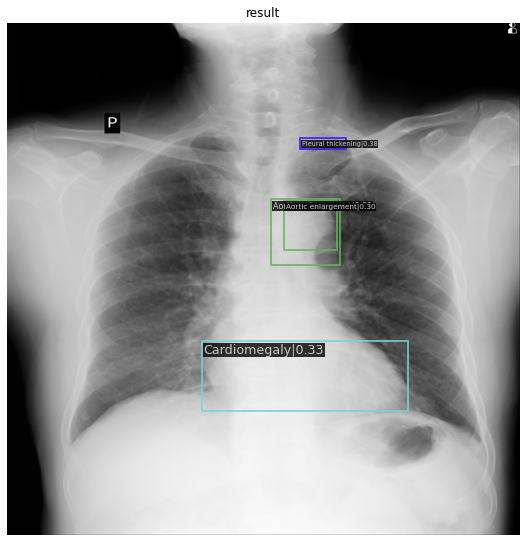

In [36]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


In [37]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (7, 5), (0, 5), (4, 5), (4, 5), (0, 5))

In [38]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [39]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [40]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(3000, 2)

In [41]:
submission.head()

,image_id,PredictionString
0,b9dcec0d41bcd2acb499745d5aeeaf08,14 1.0 0 0 1 1
1,ed8eee7061e062987cb2385657477236,14 1.0 0 0 1 1
2,b87fe4c1166680aa2e67644306baa246,14 1.0 0 0 1 1
3,3f6b6e7041b06528c5629fb7de92d61e,14 1.0 0 0 1 1
4,134214ffc7f507842719617ecd5bfc52,14 1.0 0 0 1 1


In [43]:
submission.to_csv(f'/content/drive/MyDrive/project/vinBigData/submission/yolof/mmdedtection_colab_yolof_{EPOCHS}_1.csv', index=False)